# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 893us/sample - loss: 253.8565 - y1_output_loss: 122.9194 - y2_output_loss: 128.5878 - y1_output_root_mean_squared_error: 11.1398 - y2_output_root_mean_squared_error: 11.3913 - val_loss: 38.4415 - val_y1_output_loss: 18.1608 - val_y2_output_loss: 21.6652 - val_y1_output_root_mean_squared_error: 4.1201 - val_y2_output_root_mean_squared_error: 4.6331
Epoch 2/500
614/614 [==============================] - 0s 137us/sample - loss: 30.3184 - y1_output_loss: 12.0735 - y2_output_loss: 18.7319 - y1_output_root_mean_squared_error: 3.4661 - y2_output_root_mean_squared_error: 4.2784 - val_loss: 41.6997 - val_y1_output_loss: 14.4135 - val_y2_output_loss: 26.4305 - val_y1_output_root_mean_squared_error: 3.7974 - val_y2_output_root_mean_squared_error: 5.2230
Epoch 3/500
614/614 [==============================] - 0s 136us/sample - loss: 23.7394 - y1_output_loss: 9.5576 - y2_output_loss: 14.0613 - y1_

614/614 [==============================] - 0s 125us/sample - loss: 13.6521 - y1_output_loss: 5.2829 - y2_output_loss: 8.4891 - y1_output_root_mean_squared_error: 2.2831 - y2_output_root_mean_squared_error: 2.9051 - val_loss: 16.8479 - val_y1_output_loss: 8.1487 - val_y2_output_loss: 8.9715 - val_y1_output_root_mean_squared_error: 2.7737 - val_y2_output_root_mean_squared_error: 3.0257
Epoch 22/500
614/614 [==============================] - 0s 127us/sample - loss: 13.8932 - y1_output_loss: 4.9185 - y2_output_loss: 8.8779 - y1_output_root_mean_squared_error: 2.2214 - y2_output_root_mean_squared_error: 2.9931 - val_loss: 12.4577 - val_y1_output_loss: 5.6922 - val_y2_output_loss: 6.6167 - val_y1_output_root_mean_squared_error: 2.3820 - val_y2_output_root_mean_squared_error: 2.6046
Epoch 23/500
614/614 [==============================] - 0s 123us/sample - loss: 11.2324 - y1_output_loss: 4.2701 - y2_output_loss: 7.0957 - y1_output_root_mean_squared_error: 2.0641 - y2_output_root_mean_squared_e

614/614 [==============================] - 0s 133us/sample - loss: 6.6135 - y1_output_loss: 2.1735 - y2_output_loss: 4.4310 - y1_output_root_mean_squared_error: 1.4795 - y2_output_root_mean_squared_error: 2.1035 - val_loss: 7.1389 - val_y1_output_loss: 2.5323 - val_y2_output_loss: 4.6964 - val_y1_output_root_mean_squared_error: 1.6086 - val_y2_output_root_mean_squared_error: 2.1334
Epoch 42/500
614/614 [==============================] - 0s 123us/sample - loss: 8.2578 - y1_output_loss: 2.6408 - y2_output_loss: 5.6947 - y1_output_root_mean_squared_error: 1.6229 - y2_output_root_mean_squared_error: 2.3715 - val_loss: 7.7946 - val_y1_output_loss: 2.7523 - val_y2_output_loss: 5.1100 - val_y1_output_root_mean_squared_error: 1.6632 - val_y2_output_root_mean_squared_error: 2.2424
Epoch 43/500
614/614 [==============================] - 0s 123us/sample - loss: 7.5544 - y1_output_loss: 2.4325 - y2_output_loss: 5.1357 - y1_output_root_mean_squared_error: 1.5541 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 124us/sample - loss: 5.5599 - y1_output_loss: 1.5100 - y2_output_loss: 4.0672 - y1_output_root_mean_squared_error: 1.2168 - y2_output_root_mean_squared_error: 2.0197 - val_loss: 6.5159 - val_y1_output_loss: 2.3136 - val_y2_output_loss: 4.3098 - val_y1_output_root_mean_squared_error: 1.5384 - val_y2_output_root_mean_squared_error: 2.0369
Epoch 63/500
614/614 [==============================] - 0s 122us/sample - loss: 6.8356 - y1_output_loss: 1.9407 - y2_output_loss: 4.8438 - y1_output_root_mean_squared_error: 1.3963 - y2_output_root_mean_squared_error: 2.2104 - val_loss: 4.6688 - val_y1_output_loss: 1.4109 - val_y2_output_loss: 3.2534 - val_y1_output_root_mean_squared_error: 1.1780 - val_y2_output_root_mean_squared_error: 1.8114
Epoch 64/500
614/614 [==============================] - 0s 131us/sample - loss: 5.1295 - y1_output_loss: 1.4255 - y2_output_loss: 3.6701 - y1_output_root_mean_squared_error: 1.1974 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 120us/sample - loss: 4.4828 - y1_output_loss: 1.1195 - y2_output_loss: 3.4443 - y1_output_root_mean_squared_error: 1.0590 - y2_output_root_mean_squared_error: 1.8334 - val_loss: 13.7808 - val_y1_output_loss: 1.3958 - val_y2_output_loss: 12.8219 - val_y1_output_root_mean_squared_error: 1.1970 - val_y2_output_root_mean_squared_error: 3.5140
Epoch 84/500
614/614 [==============================] - 0s 123us/sample - loss: 2.7762 - y1_output_loss: 0.7410 - y2_output_loss: 2.0237 - y1_output_root_mean_squared_error: 0.8618 - y2_output_root_mean_squared_error: 1.4260 - val_loss: 2.4675 - val_y1_output_loss: 0.6103 - val_y2_output_loss: 2.0286 - val_y1_output_root_mean_squared_error: 0.7772 - val_y2_output_root_mean_squared_error: 1.3651
Epoch 85/500
614/614 [==============================] - 0s 127us/sample - loss: 4.0536 - y1_output_loss: 1.0651 - y2_output_loss: 2.9775 - y1_output_root_mean_squared_error: 1.0345 - y2_output_root_mean

Epoch 104/500
614/614 [==============================] - 0s 126us/sample - loss: 1.9863 - y1_output_loss: 0.4581 - y2_output_loss: 1.5139 - y1_output_root_mean_squared_error: 0.6790 - y2_output_root_mean_squared_error: 1.2350 - val_loss: 1.9275 - val_y1_output_loss: 0.4102 - val_y2_output_loss: 1.5360 - val_y1_output_root_mean_squared_error: 0.6316 - val_y2_output_root_mean_squared_error: 1.2364
Epoch 105/500
614/614 [==============================] - 0s 120us/sample - loss: 3.4968 - y1_output_loss: 1.0015 - y2_output_loss: 2.4696 - y1_output_root_mean_squared_error: 1.0037 - y2_output_root_mean_squared_error: 1.5778 - val_loss: 2.0852 - val_y1_output_loss: 0.5912 - val_y2_output_loss: 1.5586 - val_y1_output_root_mean_squared_error: 0.7561 - val_y2_output_root_mean_squared_error: 1.2303
Epoch 106/500
614/614 [==============================] - 0s 128us/sample - loss: 2.5638 - y1_output_loss: 0.5508 - y2_output_loss: 2.0175 - y1_output_root_mean_squared_error: 0.7362 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 2.2775 - y1_output_loss: 0.5837 - y2_output_loss: 1.6745 - y1_output_root_mean_squared_error: 0.7669 - y2_output_root_mean_squared_error: 1.2998 - val_loss: 1.5684 - val_y1_output_loss: 0.3754 - val_y2_output_loss: 1.2302 - val_y1_output_root_mean_squared_error: 0.6147 - val_y2_output_root_mean_squared_error: 1.0911
Epoch 125/500
614/614 [==============================] - 0s 128us/sample - loss: 2.8883 - y1_output_loss: 0.6232 - y2_output_loss: 2.2594 - y1_output_root_mean_squared_error: 0.7872 - y2_output_root_mean_squared_error: 1.5062 - val_loss: 4.1310 - val_y1_output_loss: 0.7281 - val_y2_output_loss: 3.3426 - val_y1_output_root_mean_squared_error: 0.8430 - val_y2_output_root_mean_squared_error: 1.8494
Epoch 126/500
614/614 [==============================] - 0s 125us/sample - loss: 2.0401 - y1_output_loss: 0.4992 - y2_output_loss: 1.5468 - y1_output_root_mean_squared_error: 0.6997 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 127us/sample - loss: 1.6155 - y1_output_loss: 0.3095 - y2_output_loss: 1.3017 - y1_output_root_mean_squared_error: 0.5582 - y2_output_root_mean_squared_error: 1.1419 - val_loss: 1.6170 - val_y1_output_loss: 0.3141 - val_y2_output_loss: 1.3424 - val_y1_output_root_mean_squared_error: 0.5662 - val_y2_output_root_mean_squared_error: 1.1386
Epoch 146/500
614/614 [==============================] - 0s 124us/sample - loss: 2.2499 - y1_output_loss: 0.5111 - y2_output_loss: 1.7314 - y1_output_root_mean_squared_error: 0.7180 - y2_output_root_mean_squared_error: 1.3170 - val_loss: 1.7289 - val_y1_output_loss: 0.5212 - val_y2_output_loss: 1.2642 - val_y1_output_root_mean_squared_error: 0.7056 - val_y2_output_root_mean_squared_error: 1.1095
Epoch 147/500
614/614 [==============================] - 0s 124us/sample - loss: 1.9330 - y1_output_loss: 0.3877 - y2_output_loss: 1.5380 - y1_output_root_mean_squared_error: 0.6210 - y2_output_root_mea

614/614 [==============================] - 0s 137us/sample - loss: 1.7350 - y1_output_loss: 0.4213 - y2_output_loss: 1.3021 - y1_output_root_mean_squared_error: 0.6516 - y2_output_root_mean_squared_error: 1.1447 - val_loss: 1.5300 - val_y1_output_loss: 0.3230 - val_y2_output_loss: 1.2050 - val_y1_output_root_mean_squared_error: 0.5606 - val_y2_output_root_mean_squared_error: 1.1026
Epoch 166/500
614/614 [==============================] - 0s 128us/sample - loss: 1.4707 - y1_output_loss: 0.3146 - y2_output_loss: 1.1464 - y1_output_root_mean_squared_error: 0.5619 - y2_output_root_mean_squared_error: 1.0747 - val_loss: 1.2130 - val_y1_output_loss: 0.2333 - val_y2_output_loss: 0.9760 - val_y1_output_root_mean_squared_error: 0.4808 - val_y2_output_root_mean_squared_error: 0.9909
Epoch 167/500
614/614 [==============================] - 0s 123us/sample - loss: 1.7287 - y1_output_loss: 0.3840 - y2_output_loss: 1.3504 - y1_output_root_mean_squared_error: 0.6154 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 125us/sample - loss: 1.3541 - y1_output_loss: 0.2287 - y2_output_loss: 1.1129 - y1_output_root_mean_squared_error: 0.4804 - y2_output_root_mean_squared_error: 1.0599 - val_loss: 1.2395 - val_y1_output_loss: 0.2125 - val_y2_output_loss: 1.0611 - val_y1_output_root_mean_squared_error: 0.4579 - val_y2_output_root_mean_squared_error: 1.0148
Epoch 187/500
614/614 [==============================] - 0s 124us/sample - loss: 1.5664 - y1_output_loss: 0.3108 - y2_output_loss: 1.2515 - y1_output_root_mean_squared_error: 0.5589 - y2_output_root_mean_squared_error: 1.1198 - val_loss: 1.9640 - val_y1_output_loss: 0.5395 - val_y2_output_loss: 1.3811 - val_y1_output_root_mean_squared_error: 0.7359 - val_y2_output_root_mean_squared_error: 1.1927
Epoch 188/500
614/614 [==============================] - 0s 126us/sample - loss: 1.5923 - y1_output_loss: 0.3515 - y2_output_loss: 1.2348 - y1_output_root_mean_squared_error: 0.5897 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 1.2306 - y1_output_loss: 0.2541 - y2_output_loss: 0.9656 - y1_output_root_mean_squared_error: 0.5060 - y2_output_root_mean_squared_error: 0.9872 - val_loss: 0.9832 - val_y1_output_loss: 0.1684 - val_y2_output_loss: 0.8121 - val_y1_output_root_mean_squared_error: 0.4148 - val_y2_output_root_mean_squared_error: 0.9006
Epoch 207/500
614/614 [==============================] - 0s 122us/sample - loss: 1.1030 - y1_output_loss: 0.2836 - y2_output_loss: 0.8179 - y1_output_root_mean_squared_error: 0.5307 - y2_output_root_mean_squared_error: 0.9063 - val_loss: 1.9662 - val_y1_output_loss: 0.5262 - val_y2_output_loss: 1.4306 - val_y1_output_root_mean_squared_error: 0.7172 - val_y2_output_root_mean_squared_error: 1.2049
Epoch 208/500
614/614 [==============================] - 0s 128us/sample - loss: 1.3230 - y1_output_loss: 0.3303 - y2_output_loss: 0.9817 - y1_output_root_mean_squared_error: 0.5766 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 121us/sample - loss: 1.1202 - y1_output_loss: 0.2347 - y2_output_loss: 0.8841 - y1_output_root_mean_squared_error: 0.4821 - y2_output_root_mean_squared_error: 0.9422 - val_loss: 1.8803 - val_y1_output_loss: 0.4980 - val_y2_output_loss: 1.3229 - val_y1_output_root_mean_squared_error: 0.7147 - val_y2_output_root_mean_squared_error: 1.1702
Epoch 228/500
614/614 [==============================] - 0s 133us/sample - loss: 0.9466 - y1_output_loss: 0.2062 - y2_output_loss: 0.7330 - y1_output_root_mean_squared_error: 0.4557 - y2_output_root_mean_squared_error: 0.8596 - val_loss: 0.9526 - val_y1_output_loss: 0.1740 - val_y2_output_loss: 0.7609 - val_y1_output_root_mean_squared_error: 0.4240 - val_y2_output_root_mean_squared_error: 0.8791
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.7674 - y1_output_loss: 0.4340 - y2_output_loss: 1.3278 - y1_output_root_mean_squared_error: 0.6613 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 1.4151 - y1_output_loss: 0.3095 - y2_output_loss: 1.0972 - y1_output_root_mean_squared_error: 0.5572 - y2_output_root_mean_squared_error: 1.0511 - val_loss: 1.2419 - val_y1_output_loss: 0.2862 - val_y2_output_loss: 0.9446 - val_y1_output_root_mean_squared_error: 0.5435 - val_y2_output_root_mean_squared_error: 0.9729
Epoch 248/500
614/614 [==============================] - 0s 133us/sample - loss: 0.8425 - y1_output_loss: 0.1876 - y2_output_loss: 0.6519 - y1_output_root_mean_squared_error: 0.4347 - y2_output_root_mean_squared_error: 0.8084 - val_loss: 1.0446 - val_y1_output_loss: 0.1592 - val_y2_output_loss: 0.8617 - val_y1_output_root_mean_squared_error: 0.4035 - val_y2_output_root_mean_squared_error: 0.9391
Epoch 249/500
614/614 [==============================] - 0s 120us/sample - loss: 1.1710 - y1_output_loss: 0.2646 - y2_output_loss: 0.8975 - y1_output_root_mean_squared_error: 0.5164 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8424 - y1_output_loss: 0.2029 - y2_output_loss: 0.6327 - y1_output_root_mean_squared_error: 0.4524 - y2_output_root_mean_squared_error: 0.7986 - val_loss: 0.8313 - val_y1_output_loss: 0.1791 - val_y2_output_loss: 0.6421 - val_y1_output_root_mean_squared_error: 0.4201 - val_y2_output_root_mean_squared_error: 0.8092
Epoch 269/500
614/614 [==============================] - 0s 125us/sample - loss: 1.2928 - y1_output_loss: 0.3883 - y2_output_loss: 0.8989 - y1_output_root_mean_squared_error: 0.6252 - y2_output_root_mean_squared_error: 0.9497 - val_loss: 1.1816 - val_y1_output_loss: 0.1811 - val_y2_output_loss: 1.0223 - val_y1_output_root_mean_squared_error: 0.4276 - val_y2_output_root_mean_squared_error: 0.9994
Epoch 270/500
614/614 [==============================] - 0s 125us/sample - loss: 0.9820 - y1_output_loss: 0.2589 - y2_output_loss: 0.7158 - y1_output_root_mean_squared_error: 0.5108 - y2_output_root_mea

614/614 [==============================] - 0s 118us/sample - loss: 1.0287 - y1_output_loss: 0.2299 - y2_output_loss: 0.7935 - y1_output_root_mean_squared_error: 0.4805 - y2_output_root_mean_squared_error: 0.8932 - val_loss: 1.2157 - val_y1_output_loss: 0.1838 - val_y2_output_loss: 0.9960 - val_y1_output_root_mean_squared_error: 0.4326 - val_y2_output_root_mean_squared_error: 1.0142
Epoch 289/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7980 - y1_output_loss: 0.2021 - y2_output_loss: 0.6435 - y1_output_root_mean_squared_error: 0.4473 - y2_output_root_mean_squared_error: 0.7732 - val_loss: 6.1876 - val_y1_output_loss: 0.8739 - val_y2_output_loss: 5.3376 - val_y1_output_root_mean_squared_error: 0.9439 - val_y2_output_root_mean_squared_error: 2.3015
Epoch 290/500
614/614 [==============================] - 0s 126us/sample - loss: 1.3249 - y1_output_loss: 0.2671 - y2_output_loss: 1.0474 - y1_output_root_mean_squared_error: 0.5190 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 127us/sample - loss: 0.5614 - y1_output_loss: 0.1716 - y2_output_loss: 0.3863 - y1_output_root_mean_squared_error: 0.4151 - y2_output_root_mean_squared_error: 0.6238 - val_loss: 0.9186 - val_y1_output_loss: 0.1654 - val_y2_output_loss: 0.7216 - val_y1_output_root_mean_squared_error: 0.4121 - val_y2_output_root_mean_squared_error: 0.8653
Epoch 310/500
614/614 [==============================] - 0s 129us/sample - loss: 0.8570 - y1_output_loss: 0.2308 - y2_output_loss: 0.6210 - y1_output_root_mean_squared_error: 0.4825 - y2_output_root_mean_squared_error: 0.7900 - val_loss: 1.1245 - val_y1_output_loss: 0.2496 - val_y2_output_loss: 0.8368 - val_y1_output_root_mean_squared_error: 0.5061 - val_y2_output_root_mean_squared_error: 0.9319
Epoch 311/500
614/614 [==============================] - 0s 127us/sample - loss: 0.6793 - y1_output_loss: 0.2031 - y2_output_loss: 0.4955 - y1_output_root_mean_squared_error: 0.4477 - y2_output_root_mea

614/614 [==============================] - 0s 123us/sample - loss: 0.4978 - y1_output_loss: 0.1411 - y2_output_loss: 0.3531 - y1_output_root_mean_squared_error: 0.3768 - y2_output_root_mean_squared_error: 0.5964 - val_loss: 0.6330 - val_y1_output_loss: 0.1543 - val_y2_output_loss: 0.4778 - val_y1_output_root_mean_squared_error: 0.3880 - val_y2_output_root_mean_squared_error: 0.6946
Epoch 330/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5813 - y1_output_loss: 0.1577 - y2_output_loss: 0.4252 - y1_output_root_mean_squared_error: 0.3968 - y2_output_root_mean_squared_error: 0.6510 - val_loss: 1.3268 - val_y1_output_loss: 0.1845 - val_y2_output_loss: 1.1019 - val_y1_output_root_mean_squared_error: 0.4329 - val_y2_output_root_mean_squared_error: 1.0674
Epoch 331/500
614/614 [==============================] - 0s 124us/sample - loss: 0.5644 - y1_output_loss: 0.1635 - y2_output_loss: 0.4101 - y1_output_root_mean_squared_error: 0.4012 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7051 - y1_output_loss: 0.1945 - y2_output_loss: 0.5084 - y1_output_root_mean_squared_error: 0.4426 - y2_output_root_mean_squared_error: 0.7136 - val_loss: 0.9603 - val_y1_output_loss: 0.1710 - val_y2_output_loss: 0.7960 - val_y1_output_root_mean_squared_error: 0.4147 - val_y2_output_root_mean_squared_error: 0.8879
Epoch 351/500
614/614 [==============================] - 0s 123us/sample - loss: 1.4399 - y1_output_loss: 0.4409 - y2_output_loss: 0.9887 - y1_output_root_mean_squared_error: 0.6655 - y2_output_root_mean_squared_error: 0.9985 - val_loss: 0.9799 - val_y1_output_loss: 0.2087 - val_y2_output_loss: 0.7491 - val_y1_output_root_mean_squared_error: 0.4550 - val_y2_output_root_mean_squared_error: 0.8791
Epoch 352/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6118 - y1_output_loss: 0.1803 - y2_output_loss: 0.4304 - y1_output_root_mean_squared_error: 0.4248 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.6136 - y1_output_loss: 0.1450 - y2_output_loss: 0.4751 - y1_output_root_mean_squared_error: 0.3804 - y2_output_root_mean_squared_error: 0.6847 - val_loss: 2.3802 - val_y1_output_loss: 0.2489 - val_y2_output_loss: 2.0699 - val_y1_output_root_mean_squared_error: 0.5080 - val_y2_output_root_mean_squared_error: 1.4567
Epoch 371/500
614/614 [==============================] - 0s 118us/sample - loss: 0.6200 - y1_output_loss: 0.1673 - y2_output_loss: 0.4493 - y1_output_root_mean_squared_error: 0.4101 - y2_output_root_mean_squared_error: 0.6721 - val_loss: 0.6538 - val_y1_output_loss: 0.1586 - val_y2_output_loss: 0.4821 - val_y1_output_root_mean_squared_error: 0.4033 - val_y2_output_root_mean_squared_error: 0.7008
Epoch 372/500
614/614 [==============================] - 0s 124us/sample - loss: 0.4393 - y1_output_loss: 0.1284 - y2_output_loss: 0.3131 - y1_output_root_mean_squared_error: 0.3585 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 125us/sample - loss: 0.4898 - y1_output_loss: 0.1592 - y2_output_loss: 0.3270 - y1_output_root_mean_squared_error: 0.3999 - y2_output_root_mean_squared_error: 0.5743 - val_loss: 0.6740 - val_y1_output_loss: 0.1518 - val_y2_output_loss: 0.5065 - val_y1_output_root_mean_squared_error: 0.3928 - val_y2_output_root_mean_squared_error: 0.7209
Epoch 392/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4118 - y1_output_loss: 0.1432 - y2_output_loss: 0.2717 - y1_output_root_mean_squared_error: 0.3757 - y2_output_root_mean_squared_error: 0.5203 - val_loss: 0.7546 - val_y1_output_loss: 0.2074 - val_y2_output_loss: 0.5324 - val_y1_output_root_mean_squared_error: 0.4556 - val_y2_output_root_mean_squared_error: 0.7396
Epoch 393/500
614/614 [==============================] - 0s 121us/sample - loss: 0.4139 - y1_output_loss: 0.1313 - y2_output_loss: 0.2801 - y1_output_root_mean_squared_error: 0.3634 - y2_output_root_mea

614/614 [==============================] - 0s 118us/sample - loss: 0.4371 - y1_output_loss: 0.1412 - y2_output_loss: 0.2976 - y1_output_root_mean_squared_error: 0.3733 - y2_output_root_mean_squared_error: 0.5457 - val_loss: 1.1527 - val_y1_output_loss: 0.3579 - val_y2_output_loss: 0.7632 - val_y1_output_root_mean_squared_error: 0.6034 - val_y2_output_root_mean_squared_error: 0.8881
Epoch 412/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4657 - y1_output_loss: 0.1427 - y2_output_loss: 0.3215 - y1_output_root_mean_squared_error: 0.3779 - y2_output_root_mean_squared_error: 0.5682 - val_loss: 0.6739 - val_y1_output_loss: 0.1657 - val_y2_output_loss: 0.4959 - val_y1_output_root_mean_squared_error: 0.4110 - val_y2_output_root_mean_squared_error: 0.7106
Epoch 413/500
614/614 [==============================] - 0s 125us/sample - loss: 0.3924 - y1_output_loss: 0.1384 - y2_output_loss: 0.2526 - y1_output_root_mean_squared_error: 0.3735 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7284 - y1_output_loss: 0.2051 - y2_output_loss: 0.5171 - y1_output_root_mean_squared_error: 0.4548 - y2_output_root_mean_squared_error: 0.7222 - val_loss: 0.7324 - val_y1_output_loss: 0.1807 - val_y2_output_loss: 0.5368 - val_y1_output_root_mean_squared_error: 0.4246 - val_y2_output_root_mean_squared_error: 0.7430
Epoch 433/500
614/614 [==============================] - 0s 136us/sample - loss: 0.3838 - y1_output_loss: 0.1313 - y2_output_loss: 0.2495 - y1_output_root_mean_squared_error: 0.3635 - y2_output_root_mean_squared_error: 0.5016 - val_loss: 0.6824 - val_y1_output_loss: 0.2159 - val_y2_output_loss: 0.4464 - val_y1_output_root_mean_squared_error: 0.4697 - val_y2_output_root_mean_squared_error: 0.6795
Epoch 434/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5687 - y1_output_loss: 0.1655 - y2_output_loss: 0.4004 - y1_output_root_mean_squared_error: 0.4082 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.3698 - y1_output_loss: 0.1397 - y2_output_loss: 0.2280 - y1_output_root_mean_squared_error: 0.3750 - y2_output_root_mean_squared_error: 0.4787 - val_loss: 0.6122 - val_y1_output_loss: 0.1632 - val_y2_output_loss: 0.4370 - val_y1_output_root_mean_squared_error: 0.4059 - val_y2_output_root_mean_squared_error: 0.6689
Epoch 453/500
614/614 [==============================] - 0s 125us/sample - loss: 0.3720 - y1_output_loss: 0.1338 - y2_output_loss: 0.2376 - y1_output_root_mean_squared_error: 0.3664 - y2_output_root_mean_squared_error: 0.4876 - val_loss: 0.6155 - val_y1_output_loss: 0.1352 - val_y2_output_loss: 0.4680 - val_y1_output_root_mean_squared_error: 0.3679 - val_y2_output_root_mean_squared_error: 0.6929
Epoch 454/500
614/614 [==============================] - 0s 120us/sample - loss: 0.3685 - y1_output_loss: 0.1321 - y2_output_loss: 0.2367 - y1_output_root_mean_squared_error: 0.3638 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 124us/sample - loss: 0.3292 - y1_output_loss: 0.1204 - y2_output_loss: 0.2081 - y1_output_root_mean_squared_error: 0.3469 - y2_output_root_mean_squared_error: 0.4570 - val_loss: 1.0231 - val_y1_output_loss: 0.2846 - val_y2_output_loss: 0.7174 - val_y1_output_root_mean_squared_error: 0.5401 - val_y2_output_root_mean_squared_error: 0.8552
Epoch 474/500
614/614 [==============================] - 0s 125us/sample - loss: 0.4135 - y1_output_loss: 0.1216 - y2_output_loss: 0.2892 - y1_output_root_mean_squared_error: 0.3492 - y2_output_root_mean_squared_error: 0.5400 - val_loss: 0.5321 - val_y1_output_loss: 0.1332 - val_y2_output_loss: 0.3880 - val_y1_output_root_mean_squared_error: 0.3680 - val_y2_output_root_mean_squared_error: 0.6298
Epoch 475/500
614/614 [==============================] - 0s 124us/sample - loss: 0.3378 - y1_output_loss: 0.1152 - y2_output_loss: 0.2208 - y1_output_root_mean_squared_error: 0.3398 - y2_output_root_mea

614/614 [==============================] - 0s 118us/sample - loss: 0.3796 - y1_output_loss: 0.1212 - y2_output_loss: 0.2571 - y1_output_root_mean_squared_error: 0.3494 - y2_output_root_mean_squared_error: 0.5074 - val_loss: 0.8374 - val_y1_output_loss: 0.1446 - val_y2_output_loss: 0.6780 - val_y1_output_root_mean_squared_error: 0.3839 - val_y2_output_root_mean_squared_error: 0.8307
Epoch 494/500
614/614 [==============================] - 0s 127us/sample - loss: 0.4024 - y1_output_loss: 0.1454 - y2_output_loss: 0.2539 - y1_output_root_mean_squared_error: 0.3824 - y2_output_root_mean_squared_error: 0.5061 - val_loss: 0.5237 - val_y1_output_loss: 0.1418 - val_y2_output_loss: 0.3713 - val_y1_output_root_mean_squared_error: 0.3794 - val_y2_output_root_mean_squared_error: 0.6162
Epoch 495/500
614/614 [==============================] - 0s 127us/sample - loss: 0.3165 - y1_output_loss: 0.1376 - y2_output_loss: 0.1926 - y1_output_root_mean_squared_error: 0.3646 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 30us/sample - loss: 0.8079 - y1_output_loss: 0.2360 - y2_output_loss: 0.5676 - y1_output_root_mean_squared_error: 0.4885 - y2_output_root_mean_squared_error: 0.7545
Loss = 0.8079232960552364, Y1_loss = 0.2360333949327469, Y1_mse = 0.4884829521179199, Y2_loss = 0.5675923228263855, Y2_mse = 0.754524827003479


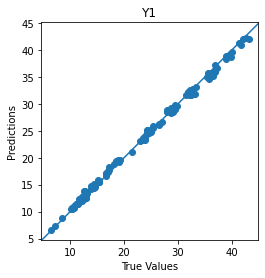

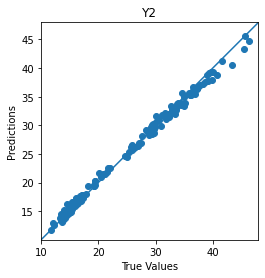

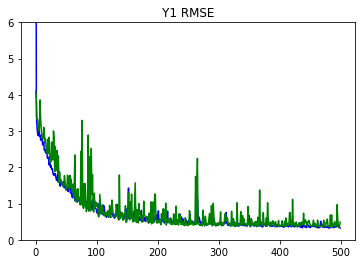

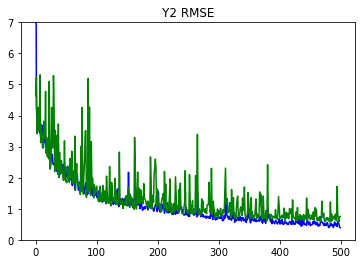

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)